In [ ]:
pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 716.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=2032da16ca81666a45ad7ca70d7e76ecd237eab78ee434a1389b9b8900847a94
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the main filled data file
data = pd.read_csv('Main_data.csv')

# Load the descriptor files
solute_descriptors = pd.read_csv('Solute_descriptors.csv')
solvent1_descriptors = pd.read_csv('Solvent_1_descriptors.csv')
solvent2_descriptors = pd.read_csv('Solvent_2_descriptors.csv')


# Renaming 'System no.' column to 'System No' in descriptor files to match the main data file
solute_descriptors.rename(columns={'System no.': 'System No'}, inplace=True)
solvent1_descriptors.rename(columns={'System no.': 'System No'}, inplace=True)
solvent2_descriptors.rename(columns={'System no.': 'System No'}, inplace=True)

# Merge descriptors with the main data
data = data.merge(solute_descriptors, on='System No', suffixes=('', '_solute'))
data = data.merge(solvent1_descriptors, on='System No', suffixes=('', '_solvent1'))
data = data.merge(solvent2_descriptors, on='System No', suffixes=('', '_solvent2'))

# Columns to normalize (excluding System No and other identifiers)
solute_columns = solute_descriptors.columns.difference(['System No']).tolist()
solvent1_columns = solvent1_descriptors.columns.difference(['System No']).tolist()
solvent2_columns = solvent2_descriptors.columns.difference(['System No']).tolist()


# Combine all features into a single dataframe for model training
features =['System No', 'x1', 'x2', 'xs1p', 'xs2p', 'Temp'] + solute_columns + [col + '_solvent1' for col in solvent1_columns] + [col + '_solvent2' for col in solvent2_columns]

final_data = data[features + ['Xs_Exper']]

# Save the preprocessed data to a new CSV file
final_data.to_csv('newpreprocessed_data.csv', index=False)

# Display the first few rows of the preprocessed data for verification



 The best solution found:
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0.]

 Objective function:
 0.0011941951084935933


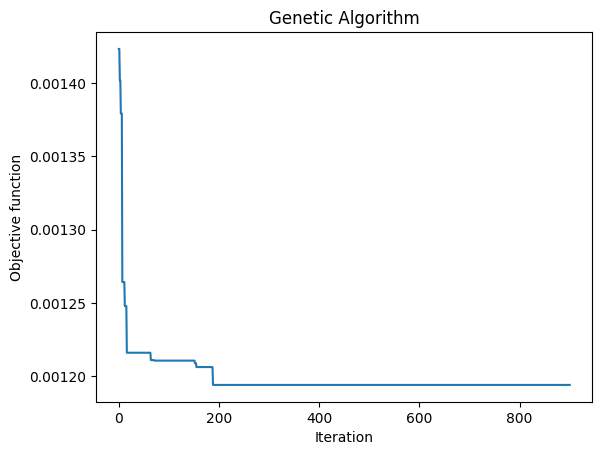

 The best solution found:
 [1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1.]

 Objective function:
 0.0030827216867440875


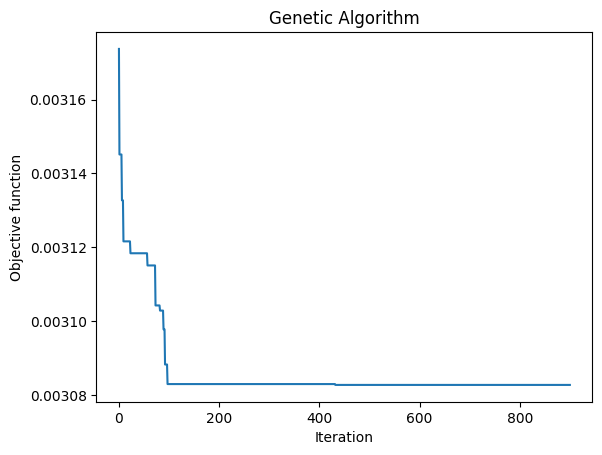

 The best solution found:
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1.]

 Objective function:
 0.0020477442721336947


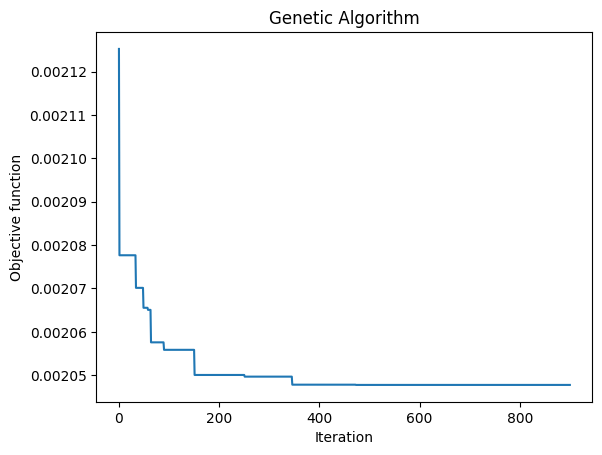

 The best solution found:
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]

 Objective function:
 0.0017869172123432633


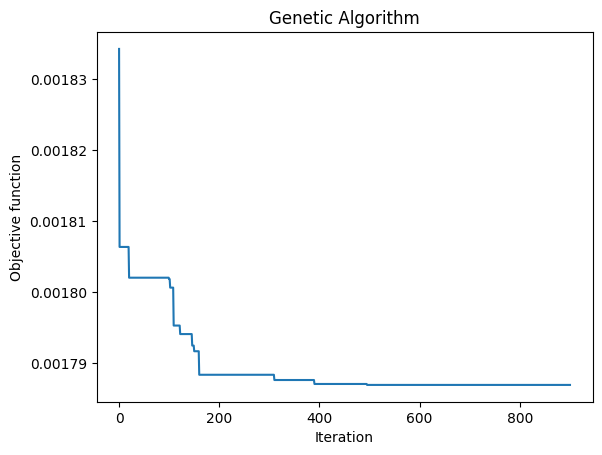

 The best solution found:
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0.]

 Objective function:
 0.001212902122301686


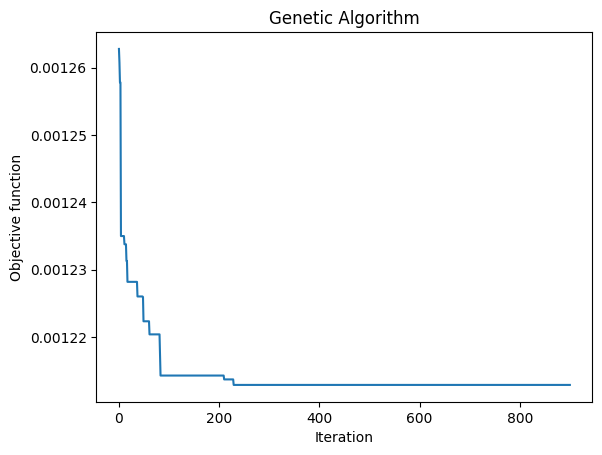

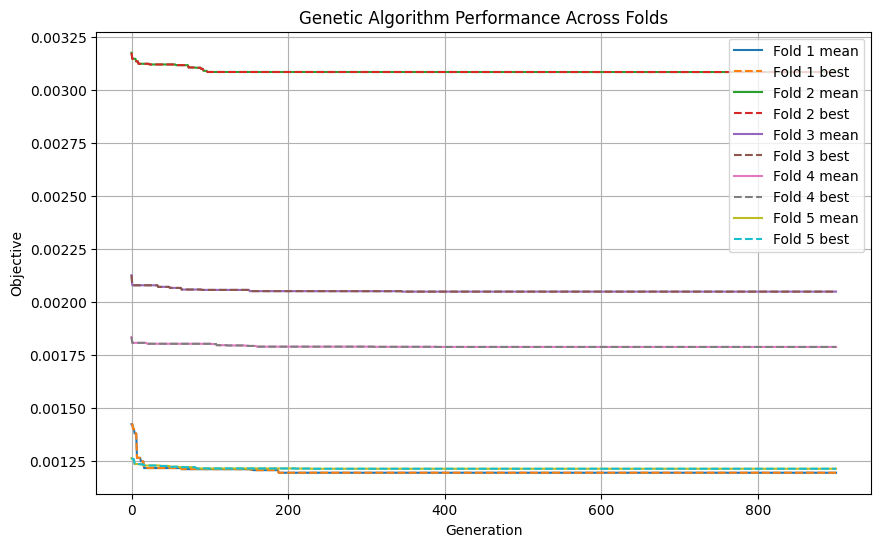

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt

# Load preprocessed data
data = pd.read_csv('newpreprocessed_data.csv')

# Define features and target
features = data.columns.difference(['Xs_Exper'])
X = data[features].values
y = data['Xs_Exper'].values

# Define the objective function for the genetic algorithm
def objective_function(selected_features):
    selected_features = [int(x) for x in selected_features]
    if sum(selected_features) == 0:
        return 1e10  # Avoid division by zero

    selected_indices = np.where(selected_features)[0]
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    mse = mean_squared_error(y_test, y_pred)
    return mse

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mean_objectives = []
best_objectives = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the genetic algorithm model
    varbound = np.array([[0, 1]] * X_train.shape[1])

    model = ga(
        function=objective_function,
        dimension=X_train.shape[1],
        variable_type='bool',
        variable_boundaries=varbound
    )

    # Run the genetic algorithm
    model.run()

    # Record the mean and best objective values
    mean_objectives.append(model.report)
    best_objectives.append(model.output_dict['function'])

# Plot the results
plt.figure(figsize=(10, 6))

for i in range(5):
    plt.plot(mean_objectives[i], label=f'Fold {i+1} mean')
    plt.plot([min(mean_objectives[i][:j+1]) for j in range(len(mean_objectives[i]))], label=f'Fold {i+1} best', linestyle='--')

plt.xlabel('Generation')
plt.ylabel('Objective')
plt.title('Genetic Algorithm Performance Across Folds')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

# Load the preprocessed data
data = pd.read_csv('newpreprocessed_data.csv')

# Separate features and target variable
X = data.drop('Xs_Exper', axis=1).values
y = data['Xs_Exper'].values

# Define the best solution from the genetic algorithm
best_solution = [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0]
selected_features = np.where(best_solution)[0]

# Select the best features from the dataset
X_selected = X[:, selected_features]

# Initialize LeaveOneOut cross-validator
loo = LeaveOneOut()

# Placeholder to store the RMSE values
rmse_values = []

# Placeholder to store actual vs predicted values for 10 samples
sample_predictions = []

# Train and test the model for each leave-one-out fold
for train_index, test_index in loo.split(X_selected):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Set negative predictions to zero
    y_pred = np.maximum(y_pred, 0)

    # Calculate the RMSE for this iteration
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_values.append(rmse)

    # Store the first 10 actual vs predicted values
    if len(sample_predictions) < 10:
        sample_predictions.append((y_test[0], y_pred[0]))

# Calculate and print the average RMSE across all iterations
average_rmse = np.mean(rmse_values)
print(f"Average RMSE: {average_rmse}")

# Print 10 sample actual vs predicted values
print("\n10 Sample Predictions:")
for i, (actual, predicted) in enumerate(sample_predictions, 1):
    print(f"Sample {i}: Actual = {actual}, Predicted = {predicted}")


Average RMSE: 0.024078318774297846

10 Sample Predictions:
Sample 1: Actual = 0.0019, Predicted = 0.0
Sample 2: Actual = 0.005, Predicted = 0.0003756738838968099
Sample 3: Actual = 0.0129, Predicted = 0.007295383490668911
Sample 4: Actual = 0.0244, Predicted = 0.014172804217189111
Sample 5: Actual = 0.0424, Predicted = 0.020979907306723
Sample 6: Actual = 0.064, Predicted = 0.02774998277033683
Sample 7: Actual = 0.0803, Predicted = 0.0345726636215615
Sample 8: Actual = 0.1078, Predicted = 0.04125319738922481
Sample 9: Actual = 0.1207, Predicted = 0.0480730616209807
Sample 10: Actual = 0.1353, Predicted = 0.0513728768446059
